Imports libs

In [13]:
from faker import Faker

from pathlib import Path 

import json
import random 
import datetime

import os
import sys

import requests

import pandas as pd 
import numpy as np

from tqdm import tqdm

import uuid


import plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected = True)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext

from joblib import Parallel, delayed

from urllib.parse import urlencode
from urllib.request import Request, urlopen
import urllib
import requests

import json
import os 
import faker

GLOBAL VARIABLES 

In [19]:
SIMULATTE_BASE_DIR = os.environ['SIMULATTE_BASE_DIR'] 
SIMULATTE_ONLINE_HOSTNAME = os.environ['SIMULATTE_ONLINE_HOSTNAME'] 
SIMULATTE_ANALYTIC_HOSTNAME = os.environ['SIMULATTE_ANALYTIC_HOSTNAME'] 
SIMULATTE_ODM_HOSTNAME = "odm" #os.environ['SIMULATTE_ODM_HOSTNAME']

Read __input data__ from __remote file__ by __url__

In [16]:
size = 10
filesize = size
if(size>999): filesize = str(size)[:-3]+"K"

payload = dict()
payload["data_sink_size"] = size
payload["data_source_url"] = "http://raw.githubusercontent.com/DecisionsDev/decisions-on-spark/master/data/miniloan/miniloan-decisions-100K.csv"
payload["data_sink_uri"] = f"{SIMULATTE_BASE_DIR}/data/ODM/loanvalidation/odm-loanvalidation-requests-{filesize}.json"

serverDjangoEndpoint = f"http://{SIMULATTE_ANALYTIC_HOSTNAME}:8000/data/from-url/" #"http://127.0.0.1:8000/data/from-url/"
headers = {'Content-type': 'application/json'} # 'Accept': 'text/plain'


def generate_from_url(data_source_url, data_sink_uri, data_sink_size):
    fake = Faker()

    # Models
    borrower = dict()
    loan = dict()
    loanRequest = dict()

    # 0 = name, 1 = creditScore, 2 = income, 3 = loanAmount, 4 = monthDuration, 5 = rate, 6 = approval,
    # 7 = yearlyReimbursement

    # credit score between 300 and 850
    # yearlyIncome 10 000 and 3 000 000
    # amount 1 000 and 1 200 000
    # duration 1 and 20*12
    # rate 0 et 0.1
    # yearly_reimbursement : internet

    # fake.name()
    file = Path(data_sink_uri)
    if file.exists():
        file = open(data_sink_uri, "r+")
        file.truncate(0)
        file.close()

    skip_header = True
    counter = 0
    start_point = 0
    for line in urllib.request.urlopen(data_source_url):
        if not skip_header and counter > start_point:
            line = line.rstrip().decode('utf-8').split(',')

            borrower["name"] = fake.name()
            borrower["creditScore"] = int(line[1].strip())
            borrower["yearlyIncome"] = int(line[2].strip())

            loan["amount"] = int(line[3].strip())
            loan["duration"] = int(line[4].strip())
            loan["yearlyInterestRate"] = float(line[5].strip())
            loan["yearlyRepayment"] = int(line[7].strip())

            loanRequest["borrower"] = borrower
            loanRequest["loan"] = loan

            with open(data_sink_uri, 'a') as file:
                file.write(json.dumps(loanRequest))
                file.write('\n')

        skip_header = False
        if counter == start_point+data_sink_size: break
        counter += 1
    

data_source_url = payload["data_source_url"]
data_sink_uri = payload["data_sink_uri"]
data_sink_size = payload["data_sink_size"]
generate_from_url(data_source_url, data_sink_uri, data_sink_size)


############## DATA FROM REMOTE CSV FILE ################
"""try:    
    response = requests.post(serverDjangoEndpoint, data = json.dumps(payload), headers=headers)
    print("RESPONSE STATUS : ", response.status_code, "\n")
    if(response.status_code==200):
        print("RESPONSE CONTENT : ", response.content, "\n")
    else:
        print("Check Django server side. ERROR : ", response.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)"""

'try:    \n    response = requests.post(serverDjangoEndpoint, data = json.dumps(payload), headers=headers)\n    print("RESPONSE STATUS : ", response.status_code, "\n")\n    if(response.status_code==200):\n        print("RESPONSE CONTENT : ", response.content, "\n")\n    else:\n        print("Check Django server side. ERROR : ", response.json()["message"])\nexcept requests.exceptions.RequestException as e:  \n    raise SystemExit(e)'

Read __input data__ from __data_source_path__ in the local file system

In [26]:
import os
import sys

import requests

import pandas as pd 
import numpy as np
import json

import tqdm

######## GET DATA #########
dataSourcePathODM = payload["data_sink_uri"]

inputData = []
with open(dataSourcePathODM) as file:
    while (line := file.readline().rstrip()):
        inputData.append(json.loads(line))

data = pd.json_normalize(inputData, max_level=1)
print(data.shape[0])
data.head(5)


10


,borrower.name,borrower.creditScore,borrower.yearlyIncome,loan.amount,loan.duration,loan.yearlyInterestRate,loan.yearlyRepayment
0,Stephen Harris,736,113243,783440,162,0.030005,70648
1,Lisa Wood,527,224186,1787385,183,0.054819,173197
2,Thomas David,460,39954,1733494,75,0.055183,328563
3,Deborah Miles,751,219998,1350004,72,0.043400,255970
4,Steven Marshall,684,72470,1210944,160,0.037772,115742


Decision service Test

In [27]:
headers = {'Content-type': 'application/json'} # 'Accept': 'text/plain'

loanRequest = inputData[0]

odmEndpoint = f"http://{SIMULATTE_ODM_HOSTNAME}:9060/DecisionService/rest/miniloan/1.0/Miniloan_ServiceRuleset"

############## DECISION TEST ################
try:    
    odmResponse = requests.post(odmEndpoint, data = json.dumps(loanRequest), headers=headers)
    print("RESPONSE STATUS : ", odmResponse.status_code, "\n")
    if(odmResponse.status_code==200):
        print("RESPONSE CONTENT : ", json.dumps(odmResponse.json(), indent=5), "\n")
    else:
        print("Check ODM server side. ERROR : ", odmResponse.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

RESPONSE STATUS :  200 

RESPONSE CONTENT :  {
     "__DecisionID__": "4c6cefc5-3139-4d48-8e77-d6246f573eeb0",
     "loan": {
          "amount": 783440,
          "duration": 162,
          "yearlyInterestRate": 0.03000493351324669,
          "yearlyRepayment": 70648,
          "approved": false,
          "messages": [
               "Too big Debt-To-Income ratio",
               "debt-to-income too high compared to credit score"
          ]
     }
} 



CREATE SIMULATION 

In [28]:
datasinkFolderPath = f"{SIMULATTE_BASE_DIR}/data/ODM/loanvalidation"
createSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulation/create"
simulationObject = {
    "name": "my simu",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": True,
    "dataSource": {
      "format": "JSON",
      "uri": dataSourcePathODM,
      "username": "string",
      "password": "string"
    },
    "dataSink": {
      "format": "JSON",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ODM",
      "endPoint": odmEndpoint,
      "authType": "NO_AUTH",
      "username": "string",
      "password": "string",
      "key": "string",
      "value": "string",
      "token": "string",
      "headerPrefix": "string"
    },
    "metrics": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "expression": "string"
      }
    ],
    "kpi": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "result": {}
      }
    ]
  }



############## CREATE SIMULATION ################
try:    
    createSimulation = requests.post(createSimulationUrl, data = json.dumps(simulationObject), headers=headers)
    print("RESPONSE STATUS : ", createSimulation.status_code, "\n")
    if(createSimulation.status_code==200):
        print("RESPONSE CONTENT : ", json.dumps(createSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", createSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)


RESPONSE STATUS :  200 

RESPONSE CONTENT :  {
     "uid": 1876,
     "userUid": 0,
     "name": "my simu",
     "description": "string",
     "createDate": "2022-09-27T13:42:59.158+00:00",
     "lastUpdateDate": "2022-09-27T13:42:59.158+00:00",
     "trace": true,
     "dataSource": {
          "format": "JSON",
          "uri": "/home/jovyan/work/data/ODM/loanvalidation/odm-loanvalidation-requests-10.json",
          "username": "string",
          "password": "string",
          "uid": 7796
     },
     "dataSink": {
          "format": "JSON",
          "folderPath": "/home/jovyan/work/data/ODM/loanvalidation",
          "uri": null,
          "username": "string",
          "password": "string",
          "uid": 7795
     },
     "decisionService": {
          "type": "ODM",
          "endPoint": "http://odm:9060/DecisionService/rest/miniloan/1.0/Miniloan_ServiceRuleset",
          "authType": "NO_AUTH",
          "operationName": null,
          "username": "string",
          "p

START SIMULATION

In [40]:
simulationUid = createSimulation.json()["uid"]
startSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/start/"
notebook_uri = f"{SIMULATTE_BASE_DIR}/notebooks/ODM/simulyticsOdm.ipynb"

run_config = {
    "name": "miniloan",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": False,
    "dataSink": {
      "format": "JSON", 
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ODM",
      "endPoint": odmEndpoint,
      "authType": "NO_AUTH",
      "username": "string",
      "password": "string",
      "key": "string",
      "value": "string",
      "token": "string",
      "headerPrefix": "string"
    },
    "executor": {
        "type": "JSE",
        "mode": "REMOTE",
        "capability": "ODM",
        "uid": 0
    },
    "optimization": False,
    "optimizationParameters": [],
    "notebookUri": notebook_uri
  }


############## START SIMULATION ################
try:    
    startSimulation = requests.post(startSimulationUrl, data = json.dumps(run_config), headers=headers)
    print("RESPONSE STATUS : ", startSimulation.status_code, "\n")
    if(startSimulation.status_code==200):
        print("YOUR SIMULATION IS STARTED !!! \n")
        print("RESPONSE CONTENT : ", json.dumps(startSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", startSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

RESPONSE STATUS :  200 

YOUR SIMULATION IS STARTED !!! 

RESPONSE CONTENT :  {
     "uid": 4050,
     "simulationUid": 1876,
     "name": "miniloan",
     "description": "string",
     "createDate": "2022-09-27T13:48:51.274+00:00",
     "trace": false,
     "optimization": false,
     "dataSource": null,
     "dataSink": {
          "format": "JSON",
          "folderPath": "/home/jovyan/work/data/ODM/loanvalidation",
          "uri": "/home/jovyan/work/data/ODM/loanvalidation/odm-22.0.1-miniloan-decisions-notrace-20220927_134851-10.json",
          "username": "string",
          "password": "string",
          "uid": 7802
     },
     "decisionService": {
          "type": "ODM",
          "endPoint": "http://odm:9060/DecisionService/rest/miniloan/1.0/Miniloan_ServiceRuleset",
          "authType": "NO_AUTH",
          "operationName": null,
          "username": "string",
          "password": "string",
          "key": "string",
          "value": "string",
          "token": "str

GET RUN REPORT

In [38]:
runReportUrl = "http://simulation-service:8080/v1/simulations/{}/runs/{}/actions/get_report"
simulationUid = startSimulation.json()["simulationUid"]
runUid = startSimulation.json()["uid"]

############## RUN REPORT ################
try:    
    runReport = requests.post(runReportUrl.format(simulationUid, runUid))
    print("RESPONSE STATUS : ", runReport.status_code, "\n")
    if(runReport.status_code==200):
        print("RUN REPORT : ", json.dumps(runReport.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", runReport.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

RESPONSE STATUS :  200 

RUN REPORT :  {
     "uid": 4049,
     "status": "FINISHED",
     "numberOfDecisions": 10,
     "numberOfRequests": 10,
     "progress": 1.0,
     "duration": 175,
     "numberOfDecisionsPerSecond": 57.142857
} 



PAUSE SIMULATION 

In [ ]:
pauseSimulationUrl = "http://simulation-server:8080/v1/simulations/{}/runs/{}/actions/pause"
simulationUid = startSimulation.json()["simulationUid"]
runUid = startSimulation.json()["uid"]

############## PAUSE SIMULATION ################
try:    
    pauseSimulation = requests.post(pauseSimulationUrl.format(simulationUid, runUid))
    print("RESPONSE STATUS : ", pauseSimulation.status_code, "\n")
    if(pauseSimulation.status_code==200):
        print("YOUR SIMULATION IS PAUSED !!! \n")
        print("RESPONSE CONTENT : ", pauseSimulation.json()["message"], "\n")
    else:
        print("Check server side. ERROR : ", pauseSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

CONTINUE TO RUN 

In [ ]:
continueSimulationUrl = "http://simulation-server:8080/v1/simulations/{}/runs/{}/actions/continue"
simulationUid = startSimulation.json()["simulationUid"]
runUid = startSimulation.json()["uid"]

############## CONTINUE SIMULATION ################
try:    
    continueSimulation = requests.post(continueSimulationUrl.format(simulationUid, runUid))
    print("RESPONSE STATUS : ", continueSimulation.status_code, "\n")
    if(continueSimulation.status_code==200):
        print("YOUR SIMULATION IS RUNNING !!! \n")
        print("RESPONSE CONTENT : ", continueSimulation.json()["message"], "\n")
    else:
        print("Check server side. ERROR : ", continueSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

READ DECISION SINK

In [47]:
datasinkPath = startSimulation.json()["dataSink"]["uri"]

outputData = []
if os.path.exists(datasinkPath):
    with open(datasinkPath) as file:
        filesize = os.path.getsize(datasinkPath)
        if filesize == 0:
            print("The file {} is empty".format(datasinkPath))
        else:
            while (line := file.readline().rstrip()):
                jsonLine = dict()
                line_to_json = json.loads(line)
                jsonLine["request"] = line_to_json["request"]
                if(line_to_json["trace"]=="empty"): 
                    jsonLine["trace"] = "empty" 
                else: 
                    jsonLine["trace"] = line_to_json["trace"]
                jsonLine["response"] = line_to_json["response"]

datasink = pd.json_normalize(outputData)
#datasink = pd.json_normalize(outputData, ["taskInformation", "ruleInformation"], ["totalTasksNotExecuted", "shortname", ["tasksNotExecuted", "taskInformation"]])
datasink.head(5)

""


GET 
- Total of approved amounts
- Total of requested amounts 
- f(yearlyIncome)=loanAmount

In [44]:
import plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected = True)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pgeocode

#Graph configs
approval_colors = ["#00CC96", "#FF6692"]
color_indices = [0, 1]

pie_chart_approval_loan_names = ['approved', 'rejected']
pie_chart_loan_amount_names = ['approved amount', 'rejected amount']
bidirectional_bar_chart_label_v2=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts']
radar_chart_labels=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts', 'ratio approved/requested']

Metrics

In [45]:
########### ODM #############
select_approved_decision = '`response.loan.approved` == True'
select_rejected_decision = '`response.loan.approved` == False'

get_decision_approval = 'response.loan.approved'
get_decision_amount = 'response.loan.amount'
get_decision_borrower_yearly_income = 'request.borrower.yearlyIncome'
get_decision_borrower_credit_score = "request.borrower.creditScore"
get_decision_id = 'response.__DecisionID__'
get_decision_reimbursement_rate = 'response.loan.yearlyInterestRate'
get_decision_yearly_repayment = 'response.loan.yearlyRepayment'

KPIs

In [46]:
########### KPI #############
approved_loan = datasink.query(select_approved_decision)
rejected_loan = datasink.query(select_rejected_decision)

########### Approved/Rejected PRINT #############
print("Number of approved loan request = ", approved_loan.shape[0])
print("Number of rejected loan request = ", rejected_loan.shape[0])
print("Rate of approval = ", approved_loan.shape[0]/datasink.shape[0])

print("Total approved amount = ",datasink.query(select_approved_decision)[get_decision_amount].sum())
print("Total rejected amount = ",datasink.query(select_rejected_decision)[get_decision_amount].sum())
print("Total requested amount = ",datasink[get_decision_amount].sum())

UndefinedVariableError: name 'BACKTICK_QUOTED_STRING_response_DOT_loan_DOT_approved' is not defined

DONUT CHART

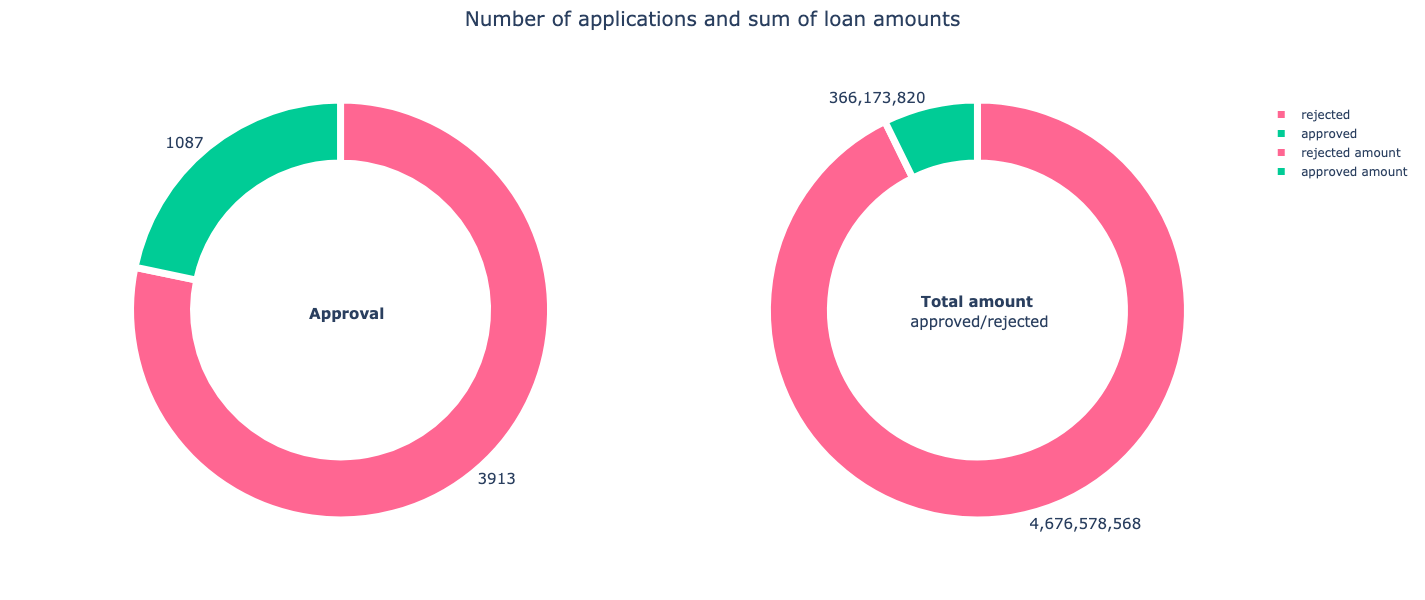

In [9]:
########### settings ###########
donut_hole = 0.7

########### Approved/Rejected PIE CHART #############
trace_approval = go.Pie(labels = pie_chart_approval_loan_names,
                            values = [approved_loan.shape[0], rejected_loan.shape[0]],
                            hole = donut_hole)

########### Approved/Rejected Amount PIE CHART #############
trace_amount = go.Pie(values= [datasink.query(select_approved_decision)[get_decision_amount].sum(),
                                 datasink.query(select_rejected_decision)[get_decision_amount].sum()],
                            labels=pie_chart_loan_amount_names,
                            hole = donut_hole,
                            name="Loan amount")

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    column_widths=[0.5, 0.5],
                    #vertical_spacing=0.001,
                    subplot_titles=("Approval", "Approved/rejected amount")
                    )

fig.add_trace(trace_approval, row=1, col=1)
fig.add_trace(trace_amount, row=1, col=2)

fig.update_traces(hoverinfo='label', textinfo='value', textfont_size=15, textposition="outside",
                  marker=dict(colors=approval_colors, line=dict(color='#FFFFFF', width=7)))
                
fig.update_annotations(yshift=20) # subplot tiltes

fig.update_layout(
    barmode='stack',
    plot_bgcolor = "white",
    #paper_bgcolor = 'lightgray',
    height=600,
    title={'text': f"Number of applications and sum of loan amounts",
          'x':0.5,
          'y':0.98,
          'xanchor': 'center',
          'font_size': 20
    },
    annotations= [
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>Approval</b>",
            "x": 0.23,
            "y": 0.42
         },
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>Total amount</b><br> approved/rejected",
            "x": 0.775,
            "y": 0.4
         }
      ],
      )

iplot(fig)

SCATTER CHART

In [10]:
def array_normalize(values, max_value=1):
    normalized_values = []
    for value in values:
        normalized_values.append((value*max_value)/max(values))
    return normalized_values

def set_colors(values, true_color="#00CC96", false_color="#FF6692"):
    colors = []
    for value in values:
        if(value): 
            colors.append(true_color) 
        else: 
            colors.append(false_color) 
    return colors

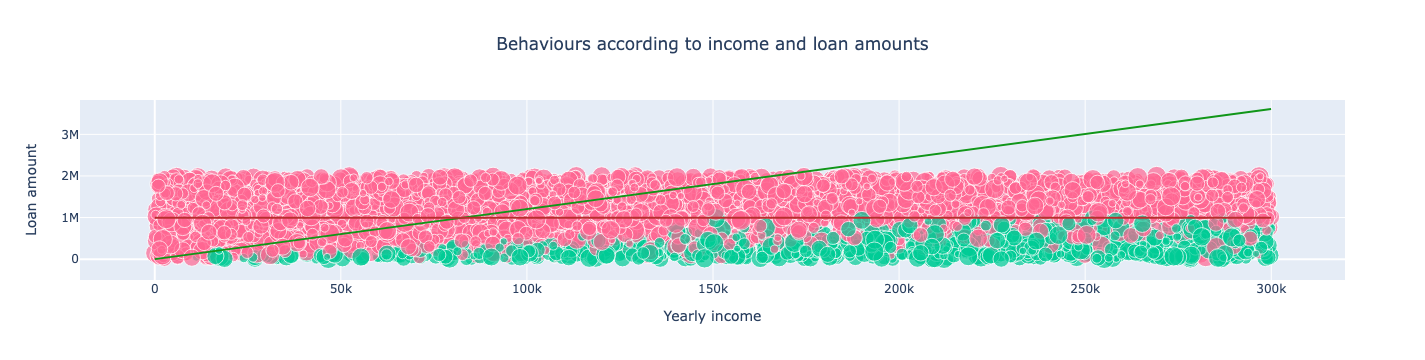

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                 x=datasink[get_decision_borrower_yearly_income],
                 y=datasink[get_decision_amount],
                 mode='markers',
                 marker_size=array_normalize(datasink[get_decision_borrower_credit_score], 20), 
                 marker_color=set_colors(datasink[get_decision_approval]),
                 text=datasink[get_decision_approval], 
                 hovertext=datasink[get_decision_id],
                 hovertemplate="<b>Income:</b> %{x}<br><b>Loan amount:</b> %{y}<br><b>Approval:</b> %{text}<br><b>Id:</b> %{hovertext}<extra></extra>",
                 name='V1'
))


fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income])]),
        y=max(datasink.query(select_approved_decision)[get_decision_amount]/datasink.query(select_approved_decision)[get_decision_borrower_yearly_income])*np.array([0, max(datasink[get_decision_borrower_yearly_income])]),
        mode="lines",
        line=go.scatter.Line(color="#109618"),
        showlegend=False)
)
fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income])]),
        y=max(datasink.query(select_approved_decision)[get_decision_amount])*np.array([1, 1]),
        mode="lines",
        line=go.scatter.Line(color="#B82E2E"),
        showlegend=False)
)


fig.update_xaxes(title_text='Yearly income')
fig.update_yaxes(title_text='Loan amount')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Behaviours according to income and loan amounts",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig)

INTEREST RATE

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                 x=datasink[get_decision_borrower_yearly_income]/12,
                 y=datasink[get_decision_yearly_repayment],
                 mode='markers',
                 marker_size=array_normalize(datasink[get_decision_borrower_credit_score], 20), 
                 marker_color=set_colors(datasink[get_decision_approval]),
                 text=datasink[get_decision_approval], 
                 hovertext=datasink[get_decision_id],
                 hovertemplate="<b>Income:</b> %{x}<br><b>Repayment:</b> %{y}<br><b>Approval:</b> %{text}<br><b>Id:</b> %{hovertext}<extra></extra>",
                 name='V1'
))

pente1 = max(datasink.query(select_approved_decision)[get_decision_yearly_repayment]*12/datasink.query(select_approved_decision)[get_decision_borrower_yearly_income])
fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income]/12)]),
        y=pente1*np.array([0, max(datasink[get_decision_borrower_yearly_income]/12)]),
        mode="lines",
        line=go.scatter.Line(color="#109618"),
        showlegend=False)
)
fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income]/12)]),
        y=max(datasink.query(select_approved_decision)[get_decision_yearly_repayment])*np.array([1, 1]),
        mode="lines",
        line=go.scatter.Line(color="#B82E2E"), ##B82E2E
        showlegend=False)
)

print("Rate : ",pente1)

Rate :  3.597101478816539


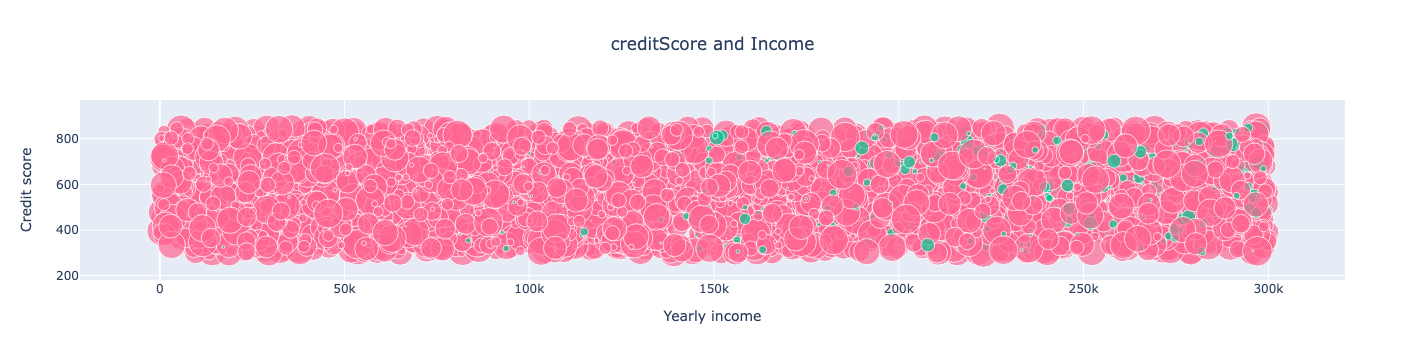

In [14]:
############ SCATTER CHART #############
fig = go.Figure()
max_marker_size = 30
fig.add_trace(go.Scatter(
                 x=datasink[get_decision_borrower_yearly_income],
                 y=datasink[get_decision_borrower_credit_score],
                 mode='markers',
                 marker_size=array_normalize(datasink[get_decision_amount], max_marker_size), 
                 marker_color=set_colors(datasink[get_decision_approval]),
                 text=datasink[get_decision_approval], 
                 hovertemplate="<b>Income:</b> %{x}<br><b>creditScore:</b> %{y}<br><b>Approval:</b> %{text}<extra></extra>",
                 name='V1'
))

fig.update_xaxes(title_text='Yearly income')
fig.update_yaxes(title_text='Credit score')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"creditScore and Income",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig)

RADAR

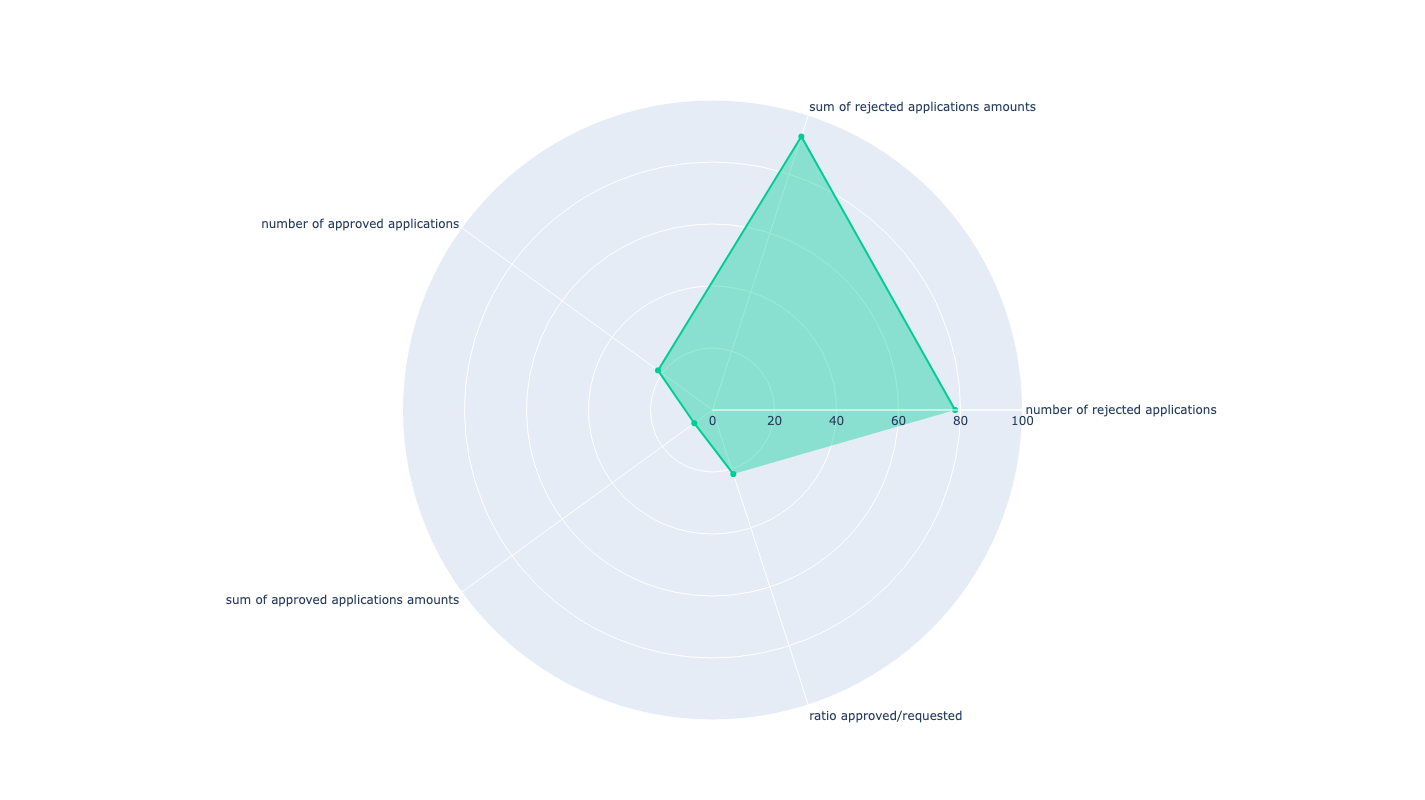

In [16]:
fig = go.Figure()

#radar dimension normalization 
radar_max_value = 100

values = np.array([[datasink.query(select_rejected_decision).shape[0], 
                    datasink.query(select_rejected_decision)[get_decision_amount].sum(), 
                    datasink.query(select_approved_decision).shape[0], 
                    datasink.query(select_approved_decision)[get_decision_amount].sum(), 
                    datasink.query(select_approved_decision).shape[0]/(datasink.query(select_approved_decision).shape[0]+datasink.query(select_rejected_decision).shape[0])
                   ],
                   [
                    datasink.shape[0],
                    datasink[get_decision_amount].sum(),
                    datasink.shape[0],
                    datasink[get_decision_amount].sum(),
                    1
                   ]
                  ])
normed_values = (values*radar_max_value) / values.max(axis=0)

def radar_normalization(values, max_value):
    normalized_values = []
    for value in values:
        normalized_values.append((value*max_value)/max(values))
    return normalized_values

fig.add_trace(go.Scatterpolar(
      r=normed_values[0],
      theta=radar_chart_labels,
      marker_color='rgb(0,204,150)',
      fillcolor='rgba(0,204,150,0.4)',
      fill='toself',
      name='V1',
))

fig.update_layout(
  height=800,
  polar=dict(
    #bgcolor= 'rgb(239, 239, 232)',
    radialaxis=dict(
      visible=True,
      range=[0, radar_max_value],
      #linecolor='red',
      #gridcolor='red',
      #axiscolor='red',
      #tickcolor='red',
    )),
  #showlegend=False
)

fig.show()

VIOLON

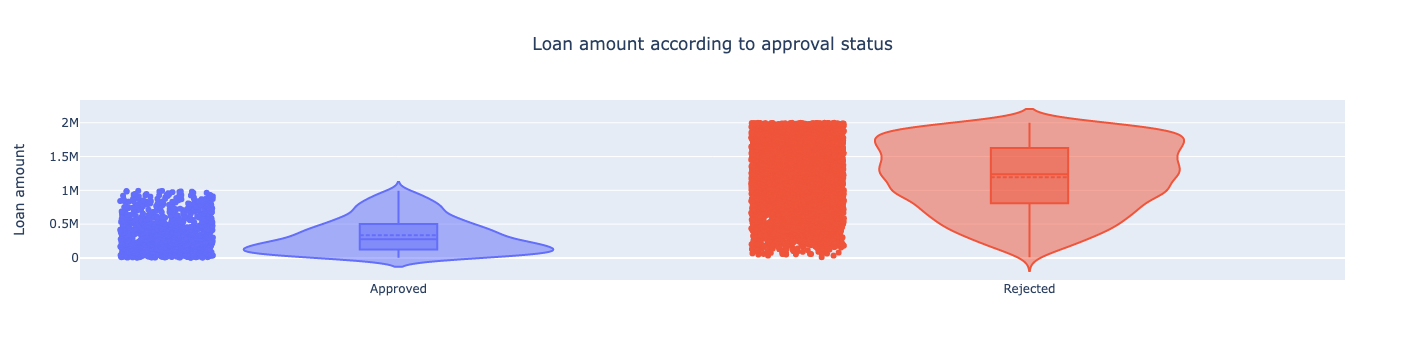

In [17]:
subplot_titles = ['Approved', 'Rejected']
select_decision_approval_status = [select_approved_decision, select_rejected_decision]
get_decision_value = [get_decision_amount, get_decision_amount]
fig = go.Figure()
for idx, approval in enumerate(select_decision_approval_status):
    fig.add_trace(go.Violin(y=datasink.query(approval)[get_decision_amount],
                            name=subplot_titles[idx],
                            box_visible=True,
                            meanline_visible=True,
                            points='all'
                            ))

fig.update_yaxes(title_text='Loan amount')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Loan amount according to approval status",
          'x':0.5,
          'xanchor': 'center'
    })

fig.show()

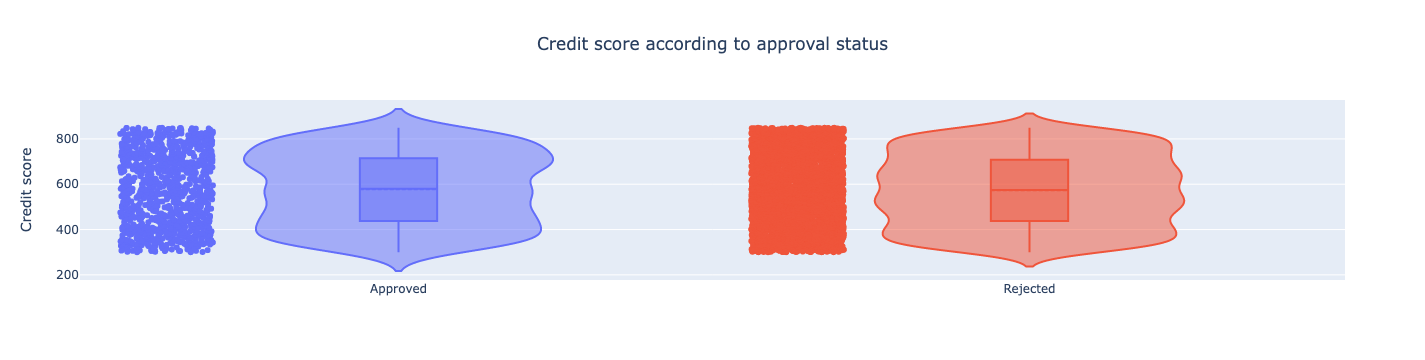

In [18]:
subplot_titles = ['Approved', 'Rejected']
select_decision_approval_status = [select_approved_decision, select_rejected_decision]
get_decision_value = [get_decision_amount, get_decision_amount]
fig = go.Figure()
for idx, approval in enumerate(select_decision_approval_status):
    fig.add_trace(go.Violin(y=datasink.query(approval)[get_decision_borrower_credit_score],
                            name=subplot_titles[idx],
                            box_visible=True,
                            meanline_visible=True,
                            points='all'
                            ))

fig.update_yaxes(title_text='Credit score')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Credit score according to approval status",
          'x':0.5,
          'xanchor': 'center'
    })

fig.show()

Get __decision details__ by __DecisionID__

In [ ]:
decisionId = "45f4e697-2ad9-4884-b974-fce5b619eca30" #id can change between two run of a simulation
#decisionId = "049545f0-985e-45f2-9f72-e8c64e0cadaf0"

decision = datasink.query('`response.__DecisionID__` == @decisionId')
print("Your decision is printed in {}.json".format(decisionId))
decision.to_json("{}.json".format(decisionId))

#print(decision)
#outputData = np.array(outputData)
#print("VALUE : ", np.where(outputData["response"]["__DecisionID__"] == decisionId))
#outputData[np.where(outputData["response"]["__DecisionID__"] == decisionId)]


Your decision is printed in 45f4e697-2ad9-4884-b974-fce5b619eca30.json


TRACE OPERATION

test

In [19]:
rules_counter = dict()

f = open(f"{SIMULATTE_BASE_DIR}/data/ODM/trace-structure.json", "r")
test_data = json.loads(f.read())

executed_rules = test_data['rulesFired']['ruleInformation'] # outputData[number_of_decision]['trace']
not_executed_rules = test_data['rulesNotFired']['ruleInformation']

for executed_rule in executed_rules: 
    if executed_rule['name'] in rules_counter:
        rules_counter[executed_rule['name']] += 1
    else :
        rules_counter[executed_rule['name']] = 1

for not_executed_rule in not_executed_rules: 
    rules_counter[not_executed_rule['name']] = 0

print("RULES COUNTER : ", rules_counter)

RULES COUNTER :  {'eligibility.minimum_credit_score': 1, 'eligibility.minimum_income': 1, 'eligibility.repayment_and_score_6': 1, 'eligibility.repayment_and_score_0': 0, 'validation.maximum_amount': 0, 'eligibility.repayment_and_score_2': 0, 'eligibility.repayment_and_score_4': 0}


COUNT NUMBER OF EXECUTION OF EACH RULE

In [40]:
rules = []
rules_counter = dict()

print(len(outputData))
for number_of_decision in range(0,len(outputData)):

    if 'ruleInformation' in outputData[number_of_decision]['trace']['rulesFired']:
        executed_rules = outputData[number_of_decision]['trace']['rulesFired']['ruleInformation']
        rules.extend(executed_rules)

        for executed_rule in executed_rules: 
            if executed_rule['name'] in rules_counter:
                rules_counter[executed_rule['name']] += 1
            else :
                rules_counter[executed_rule['name']] = 1

    if 'ruleInformation' in outputData[number_of_decision]['trace']['rulesNotFired']:
        not_executed_rules = outputData[number_of_decision]['trace']['rulesNotFired']['ruleInformation']

        for not_executed_rule in not_executed_rules: 
            if not_executed_rule['name'] not in rules_counter:
                rules_counter[not_executed_rule['name']] = 0


print(rules_counter)
rules_coverage = pd.DataFrame(rules_counter.items(), columns=['Rule', 'Count'])
rules_coverage['Percentage']= (rules_coverage['Count']*100)/datasink.shape[0]

rules_coverage

5000
{'eligibility.minimum_income': 1394, 'eligibility.repayment_and_score_6': 889, 'eligibility.repayment_and_score_0': 0, 'eligibility.minimum_credit_score': 0, 'validation.maximum_amount': 2519, 'eligibility.repayment_and_score_2': 59, 'eligibility.repayment_and_score_4': 34}


,Rule,Count,Percentage
0,eligibility.minimum_income,1394,27.88
1,eligibility.repayment_and_score_6,889,17.78
2,eligibility.repayment_and_score_0,0,0.00
3,eligibility.minimum_credit_score,0,0.00
4,validation.maximum_amount,2519,50.38
5,eligibility.repayment_and_score_2,59,1.18
6,eligibility.repayment_and_score_4,34,0.68


RULES COVERAGE

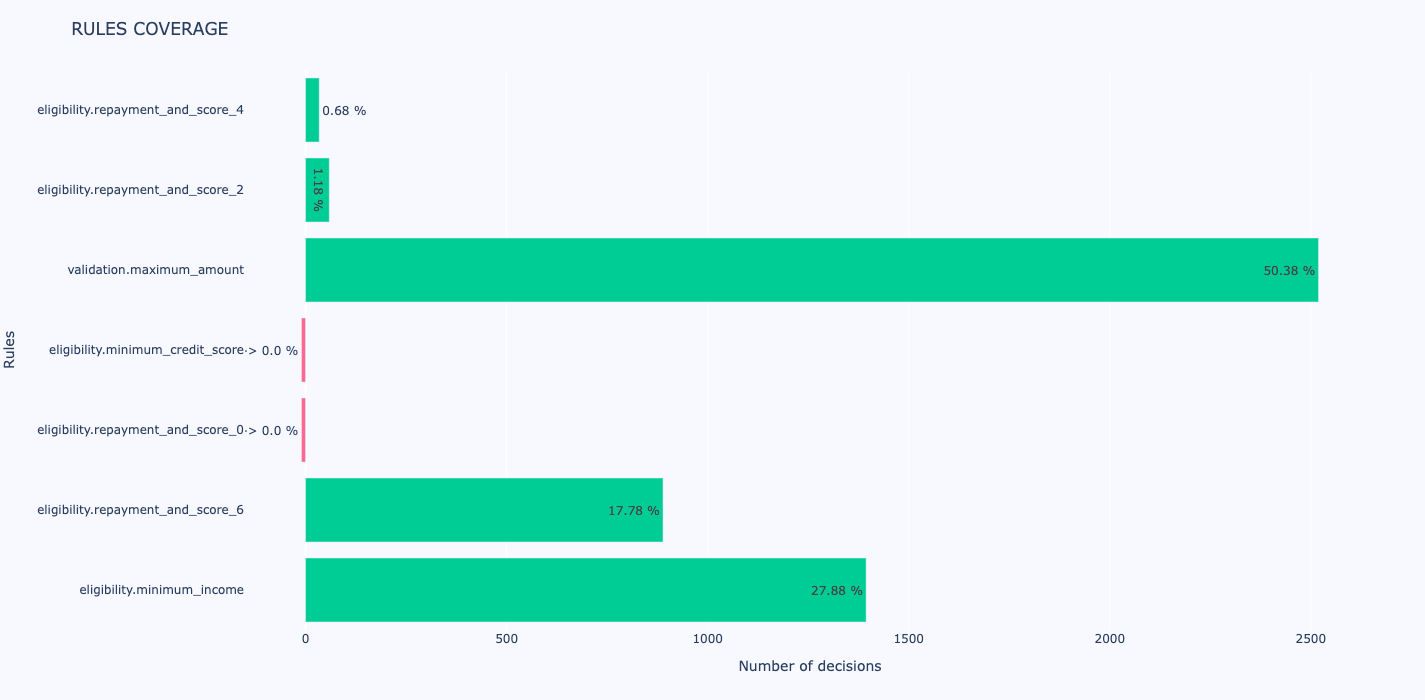

In [53]:
fig = go.Figure(go.Bar(
            x=[-10 if count==0 else count for count in rules_coverage['Count']],
            y=rules_coverage["Rule"],
            text=[f'------> {item} %' if item==0.00 else f'{item} %' for item in rules_coverage['Percentage']],
            #text=['{:.2f} %'.format(item) for item in rules_coverage['Percentage']], 
            marker_color=[px.colors.qualitative.Plotly[6] if item<=0 else px.colors.qualitative.Plotly[2] for item in rules_coverage['Percentage']],
            #textposition="inside",
            hovertemplate="<b>%{y}</b><br><b>Count:</b> %{x}<br><b>Percentage:</b> %{text}<extra></extra>",
            orientation='h'))

fig.update_xaxes(title_text='Number of decisions')
fig.update_yaxes(title_text='Rules')

fig.update_layout(
    title='RULES COVERAGE',
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=50, t=70, b=70),
    height=700,
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)
fig.show()